# Example: Area Detector & HDF5 File (default)

In [1]:
# show and explain area detector setup and HDF5 file writing
# use ADSimDetector

# similar: _ad_adsim_hdf5_custom_names.ipynb
# also: _ad_pilatus.rst

In [2]:
import pathlib

IOC = "ad:"
IMAGE_DIR = "example/%Y/%m/%d"
AD_IOC_MOUNT_PATH = pathlib.Path("/tmp")
BLUESKY_MOUNT_PATH = pathlib.Path("/tmp/docker_ioc/iocad/tmp")

In [3]:
# MUST end with a `/`, pathlib will NOT provide it
WRITE_PATH_TEMPLATE = f"{AD_IOC_MOUNT_PATH / IMAGE_DIR}/"
READ_PATH_TEMPLATE = f"{BLUESKY_MOUNT_PATH / IMAGE_DIR}/"

In [4]:
from ophyd.areadetector import SimDetectorCam
from ophyd import ADComponent
from ophyd import EpicsSignal
from ophyd import EpicsSignalRO
from ophyd import EpicsSignalWithRBV

class SimDetectorCam_R3_1_1(SimDetectorCam):
    """Revise SimDetectorCam for ADCore revisions."""
    pool_max_buffers = None
    offset = ADComponent(EpicsSignalWithRBV, "Offset")
    acquire_busy = ADComponent(EpicsSignalRO, "AcquireBusy ")
    wait_for_plugins = ADComponent(EpicsSignal, "WaitForPlugins")

    @property
    def is_acquire_busy(self):
        signal = self.acquire_busy
        return signal.get() in (1, signal.enum_strs[1])

In [5]:
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34 as HDF5Plugin

class MyHDF5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin):
    """Run HDF5 plugin in 'Single' mode."""

In [6]:
from ophyd.areadetector import DetectorBase
from ophyd.areadetector import SingleTrigger
from ophyd.areadetector.plugins import ImagePlugin_V34 as ImagePlugin

class MySimDetector(SingleTrigger, DetectorBase):
    """ADSimDetector
    
    SingleTrigger:
    
    * stop any current acquisition
    * sets image_mode to 'Multiple'
    """

    cam = ADComponent(SimDetectorCam_R3_1_1, "cam1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=WRITE_PATH_TEMPLATE,
        read_path_template=READ_PATH_TEMPLATE,
    )
    image = ADComponent(ImagePlugin, "image1:")

In [7]:
det = MySimDetector(IOC, name="det")
det.wait_for_connection(timeout=15)

In [8]:
det.read_attrs.append("hdf1")

In [9]:
det.hdf1.create_directory.put(-5)

In [10]:
# override default setting from ophyd
det.hdf1.stage_sigs["blocking_callbacks"] = "No"
det.hdf1.stage_sigs["parent.cam.wait_for_plugins"] = "Yes"

In [11]:
# det.cam.stage_sigs["acquire_period"] = 0.015
# det.cam.stage_sigs["acquire_time"] = 0.01
det.cam.stage_sigs["num_images"] = 5
det.cam.stage_sigs["parent.hdf1.num_capture"] = det.cam.stage_sigs["num_images"]
det.hdf1.stage_sigs["compression"] = "zlib"
# det.hdf1.stage_sigs["lazy_open"] = "Yes"

In [12]:
det.hdf1.stage_sigs.move_to_end("capture", last=True)

In [13]:
det.read_attrs

['hdf1']

In [14]:
det.stage_sigs

OrderedDict([('cam.acquire', 0), ('cam.image_mode', 1)])

In [15]:
det.cam.stage_sigs

OrderedDict([('num_images', 5), ('parent.hdf1.num_capture', 5)])

In [16]:
det.hdf1.stage_sigs

OrderedDict([('enable', 1),
             ('blocking_callbacks', 'No'),
             ('parent.cam.array_callbacks', 1),
             ('create_directory', -3),
             ('auto_increment', 'Yes'),
             ('array_counter', 0),
             ('auto_save', 'Yes'),
             ('num_capture', 0),
             ('file_template', '%s%s_%6.6d.h5'),
             ('file_write_mode', 'Stream'),
             ('parent.cam.wait_for_plugins', 'Yes'),
             ('compression', 'zlib'),
             ('capture', 1)])

In [17]:
from apstools.devices import AD_plugin_primed
from apstools.devices import AD_prime_plugin2

# this step is needed for ophyd
if not AD_plugin_primed(det.hdf1):
    print(f"Priming {det.hdf1.dotted_name}")
    AD_prime_plugin2(det.hdf1)

In [18]:
# Import matplotlib and put it in interactive mode.
%matplotlib inline
# %matplotlib widget
import matplotlib.pyplot as plt
plt.ion()

In [19]:
from bluesky import plans as bp
from bluesky import RunEngine
from bluesky import SupplementalData
from bluesky.callbacks.best_effort import BestEffortCallback
import databroker

cat = databroker.temp().v2
RE = RunEngine({})
RE.subscribe(cat.v1.insert)
RE.subscribe(BestEffortCallback())
RE.preprocessors.append(SupplementalData())

Note that the HDF plugin will report, briefly before acquisition, (in its `WriteMessage` PV):

> ERROR: capture is not permitted in Single mode

Ignore that.

In [20]:
uids = RE(bp.count([det], md=dict(title="Area Detector with HDF5 plugin", purpose="image")))



Transient Scan ID: 1     Time: 2022-08-03 19:25:05
Persistent Unique Scan ID: '7ff3cd06-e6a0-43ab-95ea-72ba05d7bebe'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 19:25:05.5 |
+-----------+------------+
generator count ['7ff3cd06'] (scan num: 1)





In [21]:
run = cat.v2[uids[0]]
run

BlueskyRun
  uid='7ff3cd06-e6a0-43ab-95ea-72ba05d7bebe'
  exit_status='success'
  2022-08-03 19:25:05.476 -- 2022-08-03 19:25:05.543
  Streams:
    * primary


In [22]:
dataset = run.primary.read()
dataset

<xarray.Dataset>
Dimensions:    (time: 1, dim_0: 5, dim_1: 1024, dim_2: 1024)
Coordinates:
  * time       (time) float64 1.66e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    det_image  (time, dim_0, dim_1, dim_2) uint8 0 1 2 3 4 5 ... 254 255 0 1 2

In [23]:
image = dataset["det_image"]
# image is an xarray.DataArray with 1 timestamp and 5 frames of 1k x 1k

In [24]:
frame = image[0][0]
# frame is an xarray.DataArray of 1k x 1k

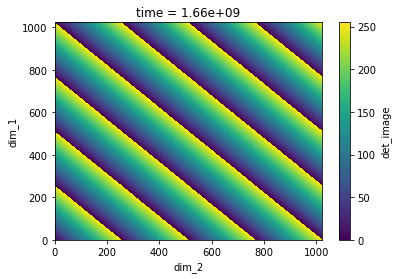

In [25]:
frame.plot.pcolormesh()